In [1]:
import Pkg
using Distributed, Plots, DelimitedFiles, Colors
length(Sys.cpu_info())
addprocs(4) ;

In [2]:
@everywhere using StatsKit, Random, DelimitedFiles

In [3]:
@everywhere W0 = 100
@everywhere M0 = 100
@everywhere Tmax = 80*365*24*3600
@everywhere Δtout = 7*24*3600 # time step to save output
@everywhere Δt = 24*3600 # time step for the simulation
@everywhere Nsim = 500 ; # number of simulations

In [4]:
@everywhere struct mtDNA 
    rates::Vector{Real}
    unique_id::Int
    parent_id::Int
    status::String
    
    function mtDNA(unique_id,parent_id,status)
        if status ∉ ["wild", "mutant"]
            error("Molecules must be of type 'wild' or 'mutant' ")
        end
        if status=="wild"
            new([6.08e-8*Δt,6.08e-8*Δt,0.0], unique_id, parent_id, status)
        elseif status=="mutant"
            new([6.08e-8*Δt,6.08e-8*Δt,0.0], unique_id, parent_id, status)
        end
    end
end 

In [5]:
@everywhere rates(mol::mtDNA) = mol.rates
@everywhere unique_id(mol::mtDNA) = mol.unique_id
@everywhere parent_id(mol::mtDNA) = mol.parent_id
@everywhere status(mol::mtDNA) = mol.status 

In [6]:
@everywhere function counter(system_state)::Vector{Int64}
    """
    Calculates the population size for wild and mutant type
    """
    copy_num = length(system_state)
    W = sum([1 for x in system_state if status(x)=="wild"])
    return [W, copy_num-W]
end

In [7]:
@everywhere function agented(init, Tmax::Real, dt::Real, out_dt::Real)
    N = trunc(Int, Tmax/dt)
    Nout = trunc(Int, Tmax/out_dt)
    system_state = init
    current_id = length(init) + 1.0
    output = fill(-1.0, (2,Nout+1))
    C0 = length(init)
    target = 0.0
    tt = 0.0
    i = 1
    for k=1:N
        if tt>=target
            output[:,i] = counter(system_state)
            target += out_dt
            i += 1
        end
        molecules_to_remove = Vector{Int}()
        new_molecules = Vector{mtDNA}()
        for mol_ind=1:length(system_state)
            molecule = system_state[mol_ind]
            roll = rand(Float64)
            cdf = cumsum( rates(molecule) ) 
            if 0.0<roll && roll<cdf[1] # degredation
                append!( molecules_to_remove, mol_ind)
            elseif cdf[1]<roll && roll<cdf[2] # replication
                append!(molecules_to_remove, mol_ind)
                for j=1:2
                    current_id += 1
                    daughter = mtDNA(current_id, unique_id(molecule), status(molecule) )
                    push!(new_molecules, daughter)
                end
            elseif cdf[2]<roll && roll<=cdf[3] # mutation
            # mutation last as has smallest probability
               append!(molecules_to_remove, mol_ind)
                for j=1:2
                    current_id += 1
                    daughter = mtDNA(current_id, unique_id(molecule), ["wild","mutant"][j])
                    push!(new_molecules, daughter)
                end
            end
        end
        system_state = [mol for (i,mol) in enumerate(system_state) if i ∉ molecules_to_remove ]
        append!(system_state, new_molecules)
        tt += dt
        if sum(counter(system_state)) == 0
            output[:,i:Nout] = fill(0.0, (2,Nout-i+1))
            return output'
        end
    end
    return output'
end

In [8]:
C0 = 200
h = 0.5
W0 = round.( C0.*(1 .-h), digits=0)
M0 = round.( C0.*h, digits=0)
inits = [mtDNA(x,-1,"wild") for x=1:W0 ]# initial state of system
append!(inits, [mtDNA(x,-1,"mutant") for x=W0+1:W0+M0] ) ;

In [9]:
@time abm_sim = agented(inits, Tmax, Δt, Δtout)
"""
one simple simulation takes 0 - 1.5 seconds
"""

  0.632223 seconds (12.01 M allocations: 454.547 MiB, 9.72% gc time, 38.21% compilation time)


"one simple simulation takes 0 - 1.5 seconds\n"

In [10]:
# The arguments are: 1) a function 'f' and 2) a list with the input.
@everywhere function simulation_map(f, lst, Tmax, dt, out_dt)
    np = nworkers()      # Number of processes available.
    Nsim  = length(lst)  # Number of elements to apply the function.
    nn =  trunc(Int, Tmax/out_dt) # dimension for output
    output = Array{Any}(undef, nn+1,2,Nsim)
    
    i = 1
    nextidx() = (idx = i; i += 1; idx) # Function to know which is the next work item.
                                       # In this case it is just an index.
    @sync begin #@sync: must complete all jobs in block
        for p = 1:np # loops through all processes (workers)
            if p != myid() || np == 1 # first worker used only if all others are busy 
                @async begin # launch several tasks simultaneaously
                    while true
                        idx = nextidx()
                        if idx > Nsim
                            break
                        end
                        output[:,:,idx] = fetch(remotecall(f, p, lst[idx], Tmax, dt, out_dt))
                    end # fetch_remotecall doesn't exist 
                end
            end
        end
    end
    output
end

In [11]:
@everywhere function raw_to_summ(sims)::Array{Float64}
    """
    converts the species populations from the gillespie algorithm to 
    copy number and mutation load
    """
    Nsim = size(sims)[3] # no. of simulations
    n = size(sims)[1] # length of one simulation
    out = Array{Float64}(undef, n,2,Nsim)
    for i=1:Nsim
        copy_num = sum(sims[:,:,i], dims=2)
        mut_load = sims[:,2,i]./copy_num
        replace_nan(copy_num)
        replace_nan(mut_load)
        out[:,:,i] = hcat(copy_num, mut_load)
    end
    out
end

In [12]:
@everywhere function replace_nan(x)
    """
    replaces NaN's caused by 0/0 in mutation load calculation
    """
    for i=eachindex(x)
        x[i] = isnan(x[i]) ? 0.0 : x[i]
    end
end

In [13]:
@everywhere function quantiles(sims, p)
    """
    returns quantile summaries from simulations
    """
    Nsim = size(sims)[3] # Nsim: number of simulations
    n = size(sims)[1] # length of one simulation
    out = Array{Float64}(undef, n,length(p),2)
    for t=1:n
        out[t,:,1] = quantile([sims[t,1,i] for i=1:Nsim], p)
        out[t,:,2] = quantile([sims[t,2,i] for i=1:Nsim], p)
    end
    out
end

In [14]:
N_list = [inits for i=1:Nsim] ;

In [15]:
@time raw_simulations = simulation_map(agented, N_list, Tmax, Δt, Δtout) ;
"""
500 simple simulations, Δt = 1 day: ~400 seconds
(simple: equal replication and degredation, no mutations and constant initial condiditions)
C0 = 200 # initial copy number
h0 = 0.5 # initial mutation load
rep & deg rate: 3.06e-6*Δt (from JPMorgan)
mut rate: 0.0
"""

356.053743 seconds (6.02 M allocations: 223.862 MiB, 0.02% gc time, 0.06% compilation time)


"1000 simple simulations ~230 seconds (170, 168, 148, 152, 294, 194)\n"

In [16]:
simulations = raw_to_summ(raw_simulations);
sims_qntl = quantiles(simulations, [0.025,0.25,0.5,0.75,0.975]) ;

In [17]:
myBlack = colorant"rgb(0,0,0,0.1)"
ts = [0:Δtout:Tmax;]./(365*24*3600);

In [18]:
p1 = plot(ts, simulations[:,1,:], color=myBlack, legend=false, title="Copy Number")
p2 = plot(ts, simulations[:,2,:], color=myBlack, legend=false, title="Mutation Load")
plot(p1, p2, layout=(1,2), legend=false)
savefig("cheekypdf.pdf")

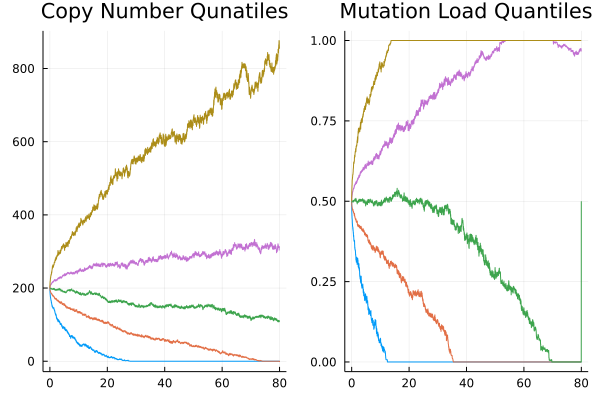

In [19]:
p3 = plot(ts, sims_qntl[:,:,1], title="Copy Number Qunatiles")
p4 = plot(ts, sims_qntl[:,:,2], title="Mutation Load Quantiles")
plot(p3, p4, layout=(1,2), legend=false)

In [20]:
writedlm("Simulations/CN_qnt_abm_jl.txt", sims_qntl[:,:,1])
writedlm("Simulations/ML_qnt_abm_jl.txt", sims_qntl[:,:,2])